In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import itertools
import yfinance as yf
import seaborn as sn
from IPython.core.display import display, HTML
from trend_following import (jupyter_interactive_mode, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             sharpe_ratio, create_trend_strategy, get_close_prices)

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
jupyter_interactive_mode()

## Helper functions to help pull the data and run the analysis

## Pull the data from Yahoo Finance

We begin by pulling daily data for the specified instrument using the Yahoo finance API. The data available only goes back to late 2017. 

In [3]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

File data found...reading ['BCH-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'BTC-USD'] data


In [4]:
def calculate_ts_momentum(df, close_px_col, lookback_period, period_name, returns_type='arithmetic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_log_returns'].rolling(window=lookback_period).sum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_pct_returns'].rolling(window=lookback_period).sum()
    
    return df

## THIS IS NON-COMPOUNDED RETURNS
def calculate_cumulative_returns(df, close_px_col, returns_type='logarithmic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_log_cum_returns'] = df[f'{close_px_col}_log_returns'].cumsum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_pct_cum_returns'] = df[f'{close_px_col}_pct_returns'].cumsum()
    
    return df

In [5]:
def get_long_and_short_term_momentum(df, close_px_col, returns_type, weekend_trading=False):
    
    if weekend_trading:
        trading_lookback_periods = [10, 21, 63, 126, 252]
    else:
        trading_lookback_periods = [10, 30, 90, 180, 365]
        
    lookback_period_names = ['10_day', '1_month', '3_month', '6_month', '12_month']
    
    c = 0
    for lookback in trading_lookback_periods:
        df = calculate_ts_momentum(df, close_px_col, lookback_period=lookback, period_name=lookback_period_names[c], returns_type=returns_type)
        c+=1
    
    return df

In [6]:
def generate_momentum_signal(df, ticker, momentum_type, threshold):#, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    df[f'{ticker}_{momentum_type}_signal'] = np.where(df[f'{ticker}_{momentum_type}'] > threshold, 1,
                                             np.where(df[f'{ticker}_{momentum_type}'] < -threshold, -1, np.nan))
    df[f'{ticker}_{momentum_type}_signal'] = df[f'{ticker}_{momentum_type}_signal'].shift(1)
    
    df[f'{ticker}_daily_returns'] = df[f'{ticker}'].pct_change()
    
#     if include_transaction_costs_and_fees:
#         average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
#         df[f'{ticker}_{momentum_type}_strategy_returns'] = (df[f'{ticker}_{momentum_type}_signal'] * df[f'{ticker}_daily_returns'] -
#                                                             (transaction_cost_est + average_fee_per_trade))
#     else:
    df[f'{ticker}_{momentum_type}_strategy_returns'] = df[f'{ticker}_{momentum_type}_signal'] * df[f'{ticker}_daily_returns']
    df[f'{ticker}_{momentum_type}_strategy_trades'] = df[f'{ticker}_{momentum_type}_signal'].diff()
    
    # Calculate cumulative returns
    df[f'{ticker}_{momentum_type}_cum_strategy_returns'] = (1 + df[f'{ticker}_{momentum_type}_strategy_returns']).cumprod() - 1
    df[f'{ticker}_{momentum_type}_cum_buy_and_hold_returns'] = (1 + df[f'{ticker}_daily_returns']).cumprod() - 1
    
    return df

In [7]:
def estimate_fee_per_trade(passive_trade_rate=0.5):
    ## Maker/Taker Fee based on lowest tier at Coinbase
    maker_fee = 0.006  # 0.6%
    taker_fee = 0.012  # 1.20%
    proportion_maker = passive_trade_rate
    proportion_taker = (1 - passive_trade_rate)

    average_fee_per_trade = (maker_fee * proportion_maker) + (taker_fee * proportion_taker)
    
    return average_fee_per_trade

In [8]:
def calculate_drawdown(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        adjusted_daily_returns = df[strategy_daily_return_col] - (np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade))
        df['strategy_cumulative_return'] = (1 + adjusted_daily_returns).cumprod() - 1
    else:
        df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1
    df[f'strategy_cumulative_return_cum_max'] = df['strategy_cumulative_return'].cummax()
    df[f'strategy_cumulative_return_drawdown'] = df['strategy_cumulative_return'] - df[f'strategy_cumulative_return_cum_max']
    df[f'strategy_cumulative_return_drawdown_pct'] = df[f'strategy_cumulative_return_drawdown'] / df[f'strategy_cumulative_return_cum_max']
    df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    
    # Calculate maximum drawdown
    max_drawdown = df[f'strategy_cumulative_return_drawdown_pct'].min()
    
    # Calculate maximum drawdown duration
    df['End'] = df.index
    df['Start'] = df[f'strategy_cumulative_return_cum_max'].ne(df[f'strategy_cumulative_return_cum_max'].shift(1)).cumsum()
    df[f'strategy_cumulative_return_DDDuration'] = df.groupby('Start')['End'].transform(lambda x: x.max() - x.min())
    max_drawdown_duration = df[f'strategy_cumulative_return_DDDuration'].max()

    # Drop NaN values for better display
#     df = df.dropna(inplace=True)
    return df, max_drawdown, max_drawdown_duration

In [9]:
def calculate_compounded_cumulative_returns(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                                            transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate cumulative return
    df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1

    # Calculate the total cumulative return at the end of the period
    total_cumulative_return = df['strategy_cumulative_return'].iloc[-1]

    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        num_trades = np.abs(df[strategy_trade_count_col]).sum()
        total_transaction_cost = num_trades * transaction_cost_est
        total_fee_cost = num_trades * average_fee_per_trade
        total_cumulative_return = total_cumulative_return - (total_transaction_cost + total_fee_cost)
    
    return total_cumulative_return

In [10]:
def calculate_CAGR(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                   transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate cumulative return
    total_cumulative_return = calculate_compounded_cumulative_returns(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col,
                                                                     annual_trading_days=annual_trading_days, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                     transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate CAGR
    # Calculate the number of periods (days)
    num_periods = len(df)

    # Convert the number of periods to years (assuming daily data, 252 trading days per year)
    trading_days_per_year = annual_trading_days
    num_years = num_periods / trading_days_per_year
    annualized_return = (1 + total_cumulative_return) ** (1 / num_years) - 1
    
    return annualized_return

In [11]:
def calculate_hit_rate(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Identify profitable trades (daily returns > 0)
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        df['profitable_trade'] = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)) > 0
    else:
        df['profitable_trade'] = df[strategy_daily_return_col] > 0

    # Calculate hit rate
    total_trades = df['profitable_trade'].count()
    profitable_trades = df['profitable_trade'].sum()
    hit_rate = profitable_trades / total_trades
    
    return hit_rate

In [12]:
from scipy import stats
def calculate_t_stat(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                    passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        mean_return = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)).mean()
        std_dev_return = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)).std()
    else:
        mean_return = df[strategy_daily_return_col].mean()
        std_dev_return = df[strategy_daily_return_col].std()
        
    num_days = len(df[strategy_daily_return_col])
    t_stat = mean_return/(std_dev_return/np.sqrt(num_days))
    p_value = stats.t.sf(np.abs(t_stat), df=num_days-1) * 2
    
    return t_stat, p_value

In [17]:
def calculate_annualized_std_dev(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                                 passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        annualized_std_dev = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) *
                              (transaction_cost_est + average_fee_per_trade)).std() * np.sqrt(annual_trading_days)
    else:
        annualized_std_dev = df[strategy_daily_return_col].std() * np.sqrt(annual_trading_days)
    
    return annualized_std_dev

In [14]:
def calculate_risk_and_performance_metrics(df, strategy_daily_return_col, strategy_trade_count_col, annual_rf=0.05, annual_trading_days=252, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                                           passive_trade_rate=0.5):
    
    # Calculate CAGR
    annualized_return = calculate_CAGR(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days,
                                       include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Annualized Sharpe Ratio
    annualized_sharpe_ratio = sharpe_ratio(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days, annual_rf=annual_rf,
                                           include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Annualized Standard Deviation
    annualized_std_dev = calculate_annualized_std_dev(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days,
                                                      include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Max Drawdown
    df, max_drawdown, max_drawdown_duration = calculate_drawdown(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, 
                                                                 include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Hit Rate
    hit_rate = calculate_hit_rate(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                  transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate T-Stat and P-Value
    t_stat, p_value = calculate_t_stat(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                       transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Count of trades
    total_num_trades = np.abs(df[strategy_trade_count_col]).sum()
    
    performance_metrics = {'annualized_return': annualized_return,
                           'annualized_sharpe_ratio': annualized_sharpe_ratio,
                           'annualized_std_dev': annualized_std_dev,
                           'max_drawdown': max_drawdown,
                           'max_drawdown_duration': max_drawdown_duration,
                           'hit_rate': hit_rate,
                           't_statistic': t_stat,
                           'p_value': p_value,
                           'trade_count': total_num_trades}
    
    return performance_metrics

In [15]:
ticker = '^VIX'
data_VIX = get_close_prices(start_date, end_date, ticker)

File data found...reading ['^VIX'] data


In [ ]:
data_VIX.head()

In [26]:
ticker_list = ['ETH-USD','XRP-USD','SOL-USD','BCH-USD','BTC-USD',]
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns',
                                                         strategy_trade_count_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_trades', annual_trading_days=365,
                                                         include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

ETH-USD
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
XRP-USD
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
SOL-USD
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
BCH-USD
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...read

In [25]:
df_final

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
ETH-USD_10_day_momentum_strategy_returns,0.877931,1.087068,1.134078,-1.090099,1103 days,0.520000,0.887277,0.375882,0.0
ETH-USD_1_month_momentum_strategy_returns,0.244045,0.685332,1.070010,-1.123188,1123 days,0.500000,0.926147,0.354752,2.0
ETH-USD_3_month_momentum_strategy_returns,-0.144142,0.290603,0.963675,-1.140881,1787 days,0.517886,0.626413,0.531161,2.0
ETH-USD_6_month_momentum_strategy_returns,0.837959,1.074831,0.866766,-2.090012,757 days,0.533925,2.351148,0.018838,2.0
ETH-USD_12_month_momentum_strategy_returns,0.137973,0.533969,0.890277,-1.586957,1048 days,0.514806,1.291416,0.196730,0.0
ETH-USD_12_month_minus_1_month_momentum_strategy_returns,-0.047961,0.321786,0.863593,-2.928503,2055 days,0.513166,0.818550,0.413157,0.0
XRP-USD_10_day_momentum_strategy_returns,-0.855810,-0.451493,1.588651,-3.976928,2170 days,0.465753,-0.325935,0.744787,0.0
XRP-USD_1_month_momentum_strategy_returns,-0.195928,0.523245,1.458367,-4.740722,1208 days,0.485265,0.657409,0.511216,2.0
XRP-USD_3_month_momentum_strategy_returns,-0.814846,-0.867878,1.163434,-2.450757,2156 days,0.476967,-1.395517,0.163157,0.0
XRP-USD_6_month_momentum_strategy_returns,NaN,-0.581670,1.066638,-3.920514,2160 days,0.494058,-0.962787,0.335852,2.0


In [19]:
df_final

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
ETH-USD_10_day_momentum_strategy_returns,0.877931,1.087068,1.134078,-1.090099,1103 days,0.520000,0.887277,0.375882,0.0
ETH-USD_1_month_momentum_strategy_returns,0.259269,0.701799,1.069753,-1.123188,1123 days,0.501706,0.947026,0.344016,2.0
ETH-USD_3_month_momentum_strategy_returns,-0.132321,0.299764,0.961943,-1.137202,1787 days,0.517886,0.643397,0.520087,2.0
ETH-USD_6_month_momentum_strategy_returns,0.838817,1.082228,0.866830,-2.090012,757 days,0.534559,2.366515,0.018077,2.0
ETH-USD_12_month_momentum_strategy_returns,0.137973,0.533969,0.890277,-1.586957,1048 days,0.514806,1.291416,0.196730,0.0
ETH-USD_12_month_minus_1_month_momentum_strategy_returns,-0.047961,0.321786,0.863593,-2.928503,2055 days,0.513166,0.818550,0.413157,0.0
XRP-USD_10_day_momentum_strategy_returns,-0.855810,-0.451493,1.588651,-3.976928,2170 days,0.465753,-0.325935,0.744787,0.0
XRP-USD_1_month_momentum_strategy_returns,-0.174161,0.536877,1.458737,-4.740722,1208 days,0.485265,0.673497,0.500938,2.0
XRP-USD_3_month_momentum_strategy_returns,-0.814846,-0.867878,1.163434,-2.450757,2156 days,0.476967,-1.395517,0.163157,0.0
XRP-USD_6_month_momentum_strategy_returns,-0.681896,-0.573602,1.066516,-3.918430,2160 days,0.494058,-0.948283,0.343180,2.0


In [ ]:
data.head()

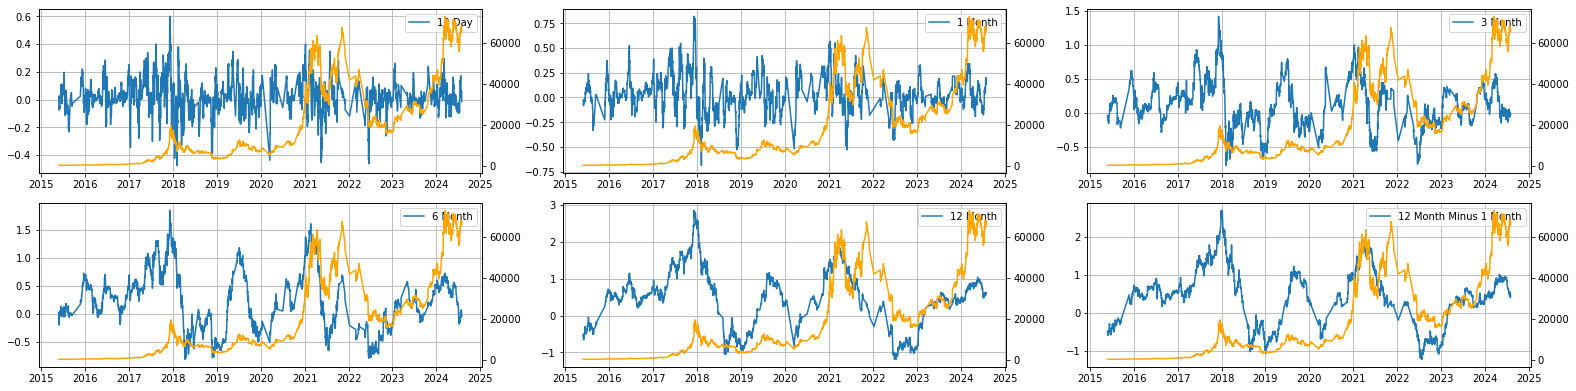

In [27]:
ticker = 'BTC-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (1,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (1,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (1,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_1 = momentum_ax_1.twinx()
_ = momentum_ax_1.plot(data.index, data[f'{ticker}_10_day_momentum'], label='10 Day')
_ = momentum_twin_ax_1.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_2 = momentum_ax_2.twinx()
_ = momentum_ax_2.plot(data.index, data[f'{ticker}_1_month_momentum'], label='1 Month')
_ = momentum_twin_ax_2.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_3 = momentum_ax_3.twinx()
_ = momentum_ax_3.plot(data.index, data[f'{ticker}_3_month_momentum'], label='3 Month')
_ = momentum_twin_ax_3.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data.index, data[ticker], label='Price', color='orange')

_ = momentum_ax_1.grid()
_ = momentum_ax_1.legend()
_ = momentum_ax_2.grid()
_ = momentum_ax_2.legend()
_ = momentum_ax_3.grid()
_ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()

plt.tight_layout()

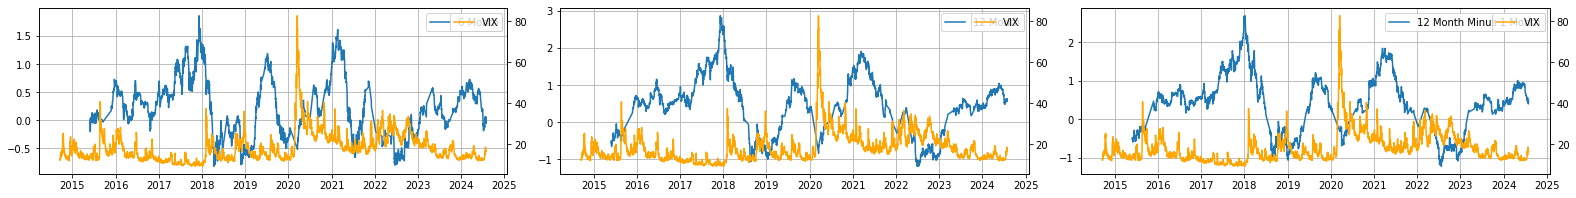

In [28]:
ticker = 'BTC-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
# momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
# momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
# momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (0,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

# _ = momentum_ax_1.grid()
# _ = momentum_ax_1.legend()
# _ = momentum_ax_2.grid()
# _ = momentum_ax_2.legend()
# _ = momentum_ax_3.grid()
# _ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_twin_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_twin_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()
_ = momentum_twin_ax_6.legend()

plt.tight_layout()

In [ ]:
data['BTC-USD'].corr(data_VIX['^VIX'])

In [ ]:
def generate_trend_signal(df, mavg_slope_col_list, ticker='BTC-USD'):
    
    def slope_signal(row):
        if all(row[i] <= row[i+1] for i in range(len(row) - 1)):
            return 'downtrend'
        elif all(row[i] >= row[i+1] for i in range(len(row) - 1)):
            return 'uptrend'
        
    df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)

    return df

In [ ]:
for end in np.linspace(200, 600, 3):
    print(end)

In [ ]:
for end in np.arange(200, 1000, 50):
    for start in np.arange(10, end, 10):
        for stepsizes in np.arange(1,10,1):
            print(start, end, end/start*stepsizes)

In [ ]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

In [ ]:
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2
ticker = 'BTC-USD'
data = create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')

In [ ]:
data.head(20)

In [ ]:
data[f'{ticker}_trend_strategy_trades'] = data[f'{ticker}_trend_signal'].diff()
data[f'{ticker}_trend_slope_strategy_trades'] = data[f'{ticker}_trend_slope_signal'].diff()

In [ ]:
df_tsla = get_close_prices(start_date, end_date, ticker='TSLA')

In [ ]:
df_tsla.head()

In [ ]:
len(ticker)

In [ ]:
data.head(10)

In [ ]:
ticker = ['SPY']
data_SPY = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data_SPY.head(10)

In [ ]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 21)
ticker = ['PL=F']
data = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [ ]:
# def create_trend_strategy(df, ticker, mavg_start, mavg_end, mavg_stepsize, vol_range_list=[10, 20, 30, 60, 90]):
    
#     for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#         df[f'{ticker}_{int(window)}_mavg'] = df[f'{ticker}'].rolling(int(window)).mean()
#         df[f'{ticker}_{int(window)}_mavg_slope'] = calculate_slope(df, column=f'{ticker}_{int(window)}_mavg', periods=window)

#     df[f'{ticker}_ribbon_thickness'] = df[f'{ticker}_{int(mavg_start)}_mavg'] - df[f'{ticker}_{int(mavg_end)}_mavg']
#     df[f'{ticker}_ribbon_thickness_diff'] = df[f'{ticker}_ribbon_thickness'].diff()
#     df = get_returns_volatility(df, vol_range_list=vol_range_list, close_px_col=ticker)

#     ## Ticker Trend Signal and Trade
#     mavg_col_list = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
#     mavg_slope_col_list = [f'{ticker}_{int(mavg)}_mavg_slope' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
#     df[f'{ticker}_trend_signal'] = df[mavg_col_list].apply(trend_signal, axis=1)
#     df[f'{ticker}_trend_signal_diff'] = df[f'{ticker}_trend_signal'].diff().shift(1)
#     df[f'{ticker}_trend_trade'] = np.where(df[f'{ticker}_trend_signal_diff'] != 0, df[f'{ticker}'], np.nan)
#     df[f'{ticker}_trend_strategy_returns'] = df[f'{ticker}_pct_returns'] * df[f'{ticker}_trend_signal_diff']
    
#     ## Ticker Trend Slope Signal and Trade
#     df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)
#     df[f'{ticker}_trend_slope_signal_diff'] = df[f'{ticker}_trend_slope_signal'].diff().shift(1)
#     df[f'{ticker}_trend_slope_trade'] = np.where(df[f'{ticker}_trend_slope_signal_diff'] != 0, df[f'{ticker}'], np.nan)
#     df[f'{ticker}_trend_slope_strategy_returns'] = df[f'{ticker}_pct_returns'] * df[f'{ticker}_trend_slope_signal_diff']
    
#     ## Drop all null values
#     df = df[df[f'{ticker}_{mavg_end}_mavg_slope'].notnull()]
    
#     ## Calculate P&L
#     df[f'{ticker}_mavg_trend_PnL'] = df[f'{ticker}_trend_signal_diff'] * df[f'{ticker}_trend_trade'] * -1
#     df[f'{ticker}_mavg_slope_PnL'] = df[f'{ticker}_trend_slope_signal_diff'] * df[f'{ticker}_trend_slope_trade'] * -1
    
#     ## Calculate Cumulative P&L
#     df[f'{ticker}_mavg_trend_PnL_cum'] = df[f'{ticker}_mavg_trend_PnL'].cumsum()
#     df[f'{ticker}_mavg_slope_PnL_cum'] = df[f'{ticker}_mavg_slope_PnL'].cumsum()
   
#     return df

In [29]:
def get_mavg_windows():
    mavg_list = []
    _mavg = []
    mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
    mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
    for i in np.arange(0,10,1):
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
    mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
    return mavg_list

In [39]:
def get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='simple', price_or_returns_calc='price', annual_trading_days=252, include_transaction_costs_and_fees=True,
                                 transaction_cost_est=0.001, passive_trade_rate=0.5):
    if isinstance(ticker_list, str):
        ticker_list = [ticker_list]
    mavg_list = get_mavg_windows()
    performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown',
                           'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    final_perf_stats = []
    
    for ticker in ticker_list:
        print(ticker)
        df_temp_results = pd.DataFrame(columns=performance_columns)
#         _results = []
        for mavg_start, mavg_end, mavg_stepsize in mavg_list:
            print(mavg_start, mavg_end, mavg_stepsize)
            df = get_close_prices(start_date, end_date, ticker)
            df = create_trend_strategy(df, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc)
#             df = df.dropna()
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_strategy_returns'] != 0).any()):
                trend_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_strategy_returns',
                                                                      strategy_trade_count_col=f'{ticker}_trend_strategy_trades',annual_trading_days=annual_trading_days,
                                                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
                trend_slope_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns',
                                                                            strategy_trade_count_col=f'{ticker}_trend_slope_strategy_trades', annual_trading_days=annual_trading_days,
                                                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_slope_metrics
#             _sharpe = sharpe_ratio(df, return_col=f'{ticker}_trend_strategy_returns', trade_col=f'{ticker}_trend_trade')
#             _pnl = df[f'{ticker}_mavg_trend_PnL'].sum()
#             _results.append([ticker, mavg_start, mavg_end, mavg_stepsize, round(_sharpe, 2), round(_pnl, 2)])
        final_perf_stats.append(df_temp_results)
#     flattened_list = [item for sublist in all_results for item in sublist]
    
#     columns = ['ticker','mavg_start','mavg_end','mavg_stepsize','sharpe_ratio','pnl']
#     df_results = pd.DataFrame(flattened_list, columns=columns)
    df_results = pd.concat(final_perf_stats, axis=0)
    
    return df_results

In [45]:
ticker_list = ['ETH-USD','SOL-USD','XRP-USD','ADA-USD','DAI-USD','DOT-USD','BTC-USD']
df_results_returns_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='returns', annual_trading_days=365, include_transaction_costs_and_fees=True)
df_results_returns_no_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='returns', annual_trading_days=365, include_transaction_costs_and_fees=False)
df_results_price_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='price', annual_trading_days=365, include_transaction_costs_and_fees=True)
df_results_price_no_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='price', annual_trading_days=365, include_transaction_costs_and_fees=False)

ETH-USD
10 100 2
File data found...reading ['ETH-USD'] data
10 100 4
File data found...reading ['ETH-USD'] data
10 100 10
File data found...reading ['ETH-USD'] data
20 200 2
File data found...reading ['ETH-USD'] data
20 200 4
File data found...reading ['ETH-USD'] data
20 200 10
File data found...reading ['ETH-USD'] data
20 200 19
File data found...reading ['ETH-USD'] data
30 300 2
File data found...reading ['ETH-USD'] data
30 300 4
File data found...reading ['ETH-USD'] data
30 300 10
File data found...reading ['ETH-USD'] data
30 300 28
File data found...reading ['ETH-USD'] data
40 400 2
File data found...reading ['ETH-USD'] data
40 400 4
File data found...reading ['ETH-USD'] data
40 400 10
File data found...reading ['ETH-USD'] data
40 400 37
File data found...reading ['ETH-USD'] data
50 500 2
File data found...reading ['ETH-USD'] data
50 500 4
File data found...reading ['ETH-USD'] data
50 500 10
File data found...reading ['ETH-USD'] data
50 500 46
File data found...reading ['ETH-USD'] 

100 1000 91
File data found...reading ['ADA-USD'] data
DAI-USD
10 100 2
File data found...reading ['DAI-USD'] data
10 100 4
File data found...reading ['DAI-USD'] data
10 100 10
File data found...reading ['DAI-USD'] data
20 200 2
File data found...reading ['DAI-USD'] data
20 200 4
File data found...reading ['DAI-USD'] data
20 200 10
File data found...reading ['DAI-USD'] data
20 200 19
File data found...reading ['DAI-USD'] data
30 300 2
File data found...reading ['DAI-USD'] data
30 300 4
File data found...reading ['DAI-USD'] data
30 300 10
File data found...reading ['DAI-USD'] data
30 300 28
File data found...reading ['DAI-USD'] data
40 400 2
File data found...reading ['DAI-USD'] data
40 400 4
File data found...reading ['DAI-USD'] data
40 400 10
File data found...reading ['DAI-USD'] data
40 400 37
File data found...reading ['DAI-USD'] data
50 500 2
File data found...reading ['DAI-USD'] data
50 500 4
File data found...reading ['DAI-USD'] data
50 500 10
File data found...reading ['DAI-USD'

100 1000 10
File data found...reading ['ETH-USD'] data
100 1000 91
File data found...reading ['ETH-USD'] data
SOL-USD
10 100 2
File data found...reading ['SOL-USD'] data
10 100 4
File data found...reading ['SOL-USD'] data
10 100 10
File data found...reading ['SOL-USD'] data
20 200 2
File data found...reading ['SOL-USD'] data
20 200 4
File data found...reading ['SOL-USD'] data
20 200 10
File data found...reading ['SOL-USD'] data
20 200 19
File data found...reading ['SOL-USD'] data
30 300 2
File data found...reading ['SOL-USD'] data
30 300 4
File data found...reading ['SOL-USD'] data
30 300 10
File data found...reading ['SOL-USD'] data
30 300 28
File data found...reading ['SOL-USD'] data
40 400 2
File data found...reading ['SOL-USD'] data
40 400 4
File data found...reading ['SOL-USD'] data
40 400 10
File data found...reading ['SOL-USD'] data
40 400 37
File data found...reading ['SOL-USD'] data
50 500 2
File data found...reading ['SOL-USD'] data
50 500 4
File data found...reading ['SOL-US

100 1000 91
File data found...reading ['DAI-USD'] data
DOT-USD
10 100 2
File data found...reading ['DOT-USD'] data
10 100 4
File data found...reading ['DOT-USD'] data
10 100 10
File data found...reading ['DOT-USD'] data
20 200 2
File data found...reading ['DOT-USD'] data
20 200 4
File data found...reading ['DOT-USD'] data
20 200 10
File data found...reading ['DOT-USD'] data
20 200 19
File data found...reading ['DOT-USD'] data
30 300 2
File data found...reading ['DOT-USD'] data
30 300 4
File data found...reading ['DOT-USD'] data
30 300 10
File data found...reading ['DOT-USD'] data
30 300 28
File data found...reading ['DOT-USD'] data
40 400 2
File data found...reading ['DOT-USD'] data
40 400 4
File data found...reading ['DOT-USD'] data
40 400 10
File data found...reading ['DOT-USD'] data
40 400 37
File data found...reading ['DOT-USD'] data
50 500 2
File data found...reading ['DOT-USD'] data
50 500 4
File data found...reading ['DOT-USD'] data
50 500 10
File data found...reading ['DOT-USD'

XRP-USD
10 100 2
File data found...reading ['XRP-USD'] data
10 100 4
File data found...reading ['XRP-USD'] data
10 100 10
File data found...reading ['XRP-USD'] data
20 200 2
File data found...reading ['XRP-USD'] data
20 200 4
File data found...reading ['XRP-USD'] data
20 200 10
File data found...reading ['XRP-USD'] data
20 200 19
File data found...reading ['XRP-USD'] data
30 300 2
File data found...reading ['XRP-USD'] data
30 300 4
File data found...reading ['XRP-USD'] data
30 300 10
File data found...reading ['XRP-USD'] data
30 300 28
File data found...reading ['XRP-USD'] data
40 400 2
File data found...reading ['XRP-USD'] data
40 400 4
File data found...reading ['XRP-USD'] data
40 400 10
File data found...reading ['XRP-USD'] data
40 400 37
File data found...reading ['XRP-USD'] data
50 500 2
File data found...reading ['XRP-USD'] data
50 500 4
File data found...reading ['XRP-USD'] data
50 500 10
File data found...reading ['XRP-USD'] data
50 500 46
File data found...reading ['XRP-USD'] 

BTC-USD
10 100 2
File data found...reading ['BTC-USD'] data
10 100 4
File data found...reading ['BTC-USD'] data
10 100 10
File data found...reading ['BTC-USD'] data
20 200 2
File data found...reading ['BTC-USD'] data
20 200 4
File data found...reading ['BTC-USD'] data
20 200 10
File data found...reading ['BTC-USD'] data
20 200 19
File data found...reading ['BTC-USD'] data
30 300 2
File data found...reading ['BTC-USD'] data
30 300 4
File data found...reading ['BTC-USD'] data
30 300 10
File data found...reading ['BTC-USD'] data
30 300 28
File data found...reading ['BTC-USD'] data
40 400 2
File data found...reading ['BTC-USD'] data
40 400 4
File data found...reading ['BTC-USD'] data
40 400 10
File data found...reading ['BTC-USD'] data
40 400 37
File data found...reading ['BTC-USD'] data
50 500 2
File data found...reading ['BTC-USD'] data
50 500 4
File data found...reading ['BTC-USD'] data
50 500 10
File data found...reading ['BTC-USD'] data
50 500 46
File data found...reading ['BTC-USD'] 

100 1000 91
File data found...reading ['XRP-USD'] data
ADA-USD
10 100 2
File data found...reading ['ADA-USD'] data
10 100 4
File data found...reading ['ADA-USD'] data
10 100 10
File data found...reading ['ADA-USD'] data
20 200 2
File data found...reading ['ADA-USD'] data
20 200 4
File data found...reading ['ADA-USD'] data
20 200 10
File data found...reading ['ADA-USD'] data
20 200 19
File data found...reading ['ADA-USD'] data
30 300 2
File data found...reading ['ADA-USD'] data
30 300 4
File data found...reading ['ADA-USD'] data
30 300 10
File data found...reading ['ADA-USD'] data
30 300 28
File data found...reading ['ADA-USD'] data
40 400 2
File data found...reading ['ADA-USD'] data
40 400 4
File data found...reading ['ADA-USD'] data
40 400 10
File data found...reading ['ADA-USD'] data
40 400 37
File data found...reading ['ADA-USD'] data
50 500 2
File data found...reading ['ADA-USD'] data
50 500 4
File data found...reading ['ADA-USD'] data
50 500 10
File data found...reading ['ADA-USD'

100 1000 10
File data found...reading ['BTC-USD'] data
100 1000 91
File data found...reading ['BTC-USD'] data


In [46]:
df_results_returns_t_cost

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
ETH-USD_10-100-2_trend_strategy_returns,NaN,-0.903686,0.868853,-1.739683,2239 days,0.447983,-2.152796,3.143601e-02,842.0
ETH-USD_10-100-2_trend_slope_strategy_returns,70.361817,3.940778,0.800903,-3.151676,104 days,0.553715,10.164678,8.762850e-24,911.0
ETH-USD_10-100-4_trend_strategy_returns,NaN,-0.826331,0.707262,-1.808360,2255 days,0.273885,-1.923716,5.451067e-02,630.0
ETH-USD_10-100-4_trend_slope_strategy_returns,6.511602,2.998735,0.490043,-1.582633,136 days,0.156263,7.869970,5.362662e-15,402.0
ETH-USD_10-100-10_trend_strategy_returns,NaN,-0.823221,0.653027,-1.824800,2148 days,0.219958,-1.901263,5.738956e-02,596.0
ETH-USD_10-100-10_trend_slope_strategy_returns,0.260305,0.773389,0.213103,-0.157110,662 days,0.010191,2.546073,1.095744e-02,32.0
ETH-USD_20-200-2_trend_strategy_returns,NaN,-0.634291,0.859760,-208.662422,2224 days,0.460310,-1.435516,1.512790e-01,560.0
ETH-USD_20-200-2_trend_slope_strategy_returns,24.823581,3.146974,0.811802,-0.811387,106 days,0.549002,7.971436,2.468155e-15,615.0
ETH-USD_20-200-4_trend_strategy_returns,NaN,-0.307454,0.680090,-36.560046,1428 days,0.300222,-0.585870,5.580213e-01,370.0
ETH-USD_20-200-4_trend_slope_strategy_returns,3.079317,2.073273,0.477603,-0.369051,202 days,0.149002,5.407211,7.077176e-08,298.0


In [47]:
df_results_price_t_cost

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
ETH-USD_10-100-2_trend_strategy_returns,0.231396,0.548002,0.854574,-6.241939,773 days,0.515705,1.537331,1.243466e-01,54.0
ETH-USD_10-100-2_trend_slope_strategy_returns,1.920509,1.247644,0.848170,-2.821880,690 days,0.505518,3.315957,9.271602e-04,209.0
ETH-USD_10-100-4_trend_strategy_returns,0.411559,0.663636,0.700769,-2.755448,1176 days,0.367997,1.862953,6.259335e-02,56.0
ETH-USD_10-100-4_trend_slope_strategy_returns,0.405470,0.549720,0.461588,-1.242249,1176 days,0.141766,1.665198,9.600625e-02,104.0
ETH-USD_10-100-10_trend_strategy_returns,0.425685,0.622954,0.636573,-1.271594,1176 days,0.297963,1.777433,7.562600e-02,80.0
ETH-USD_10-100-10_trend_slope_strategy_returns,-0.043343,-0.242884,0.248718,-1.894685,1176 days,0.032683,-0.118657,9.055573e-01,50.0
ETH-USD_20-200-2_trend_strategy_returns,0.265627,0.621016,0.847719,-1.956035,1048 days,0.525709,1.687021,9.173758e-02,22.0
ETH-USD_20-200-2_trend_slope_strategy_returns,0.739309,0.832482,0.845871,-2.156279,717 days,0.510195,2.213066,2.699288e-02,101.0
ETH-USD_20-200-4_trend_strategy_returns,0.022874,0.332780,0.755692,-2.156279,872 days,0.382535,0.987856,3.233292e-01,36.0
ETH-USD_20-200-4_trend_slope_strategy_returns,0.341049,0.575827,0.525755,-5.443729,1176 days,0.175089,1.662307,9.659027e-02,58.0


In [48]:
df_results_returns_no_t_cost

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
ETH-USD_10-100-2_trend_strategy_returns,0.232513,0.609046,0.853532,-1.220520,1601 days,0.485350,1.692239,9.073281e-02,842.0
ETH-USD_10-100-2_trend_slope_strategy_returns,70.361817,5.576797,0.819132,-1.438650,38 days,0.609766,14.316869,1.216203e-44,911.0
ETH-USD_10-100-4_trend_strategy_returns,0.221653,0.560265,0.699670,-1.125228,1298 days,0.294692,1.600262,1.096746e-01,630.0
ETH-USD_10-100-4_trend_slope_strategy_returns,6.511612,4.130831,0.506573,-0.369262,94 days,0.165605,10.737343,2.731645e-26,402.0
ETH-USD_10-100-10_trend_strategy_returns,0.258269,0.596759,0.647080,-1.125228,1298 days,0.236518,1.707358,8.788749e-02,596.0
ETH-USD_10-100-10_trend_slope_strategy_returns,0.273945,0.963931,0.222431,-0.124337,662 days,0.010616,3.005676,2.677904e-03,32.0
ETH-USD_20-200-2_trend_strategy_returns,0.055464,0.425970,0.847695,-14.575392,1287 days,0.488248,1.201849,2.295483e-01,560.0
ETH-USD_20-200-2_trend_slope_strategy_returns,24.823581,4.294039,0.826768,-1.883612,95 days,0.585809,10.819846,1.235878e-26,615.0
ETH-USD_20-200-4_trend_strategy_returns,0.235340,0.578857,0.673388,-2.708998,1298 days,0.313525,1.618895,1.056097e-01,370.0
ETH-USD_20-200-4_trend_slope_strategy_returns,3.079650,3.003016,0.490357,-0.305741,152 days,0.156541,7.711551,1.851339e-14,298.0


In [49]:
df_results_price_no_t_cost

,annualized_return,annualized_sharpe_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
ETH-USD_10-100-2_trend_strategy_returns,0.256801,0.646800,0.853381,-5.701740,773 days,0.519525,1.788543,7.381699e-02,54.0
ETH-USD_10-100-2_trend_slope_strategy_returns,1.921444,1.624610,0.850669,-1.206091,478 days,0.517402,4.273259,2.002984e-05,209.0
ETH-USD_10-100-4_trend_strategy_returns,0.424468,0.787983,0.700285,-1.694394,1176 days,0.370119,2.178993,2.943099e-02,56.0
ETH-USD_10-100-4_trend_slope_strategy_returns,0.429488,0.896510,0.462755,-0.776818,1029 days,0.147284,2.545586,1.097268e-02,104.0
ETH-USD_10-100-10_trend_strategy_returns,0.443008,0.818874,0.635622,-1.199799,1176 days,0.298812,2.275486,2.296624e-02,80.0
ETH-USD_10-100-10_trend_slope_strategy_returns,0.035335,0.067771,0.251615,-1.442532,1176 days,0.034380,0.664863,5.062033e-01,50.0
ETH-USD_20-200-2_trend_strategy_returns,0.275912,0.662699,0.848109,-1.956035,875 days,0.526596,1.790584,7.349421e-02,22.0
ETH-USD_20-200-2_trend_slope_strategy_returns,0.748472,1.023870,0.847355,-1.956035,717 days,0.515957,2.688629,7.227401e-03,101.0
ETH-USD_20-200-4_trend_strategy_returns,0.068952,0.410467,0.754564,-1.956035,870 days,0.382979,1.181237,2.376332e-01,36.0
ETH-USD_20-200-4_trend_slope_strategy_returns,0.360797,0.755709,0.524783,-3.592855,1176 days,0.176862,2.109943,3.497320e-02,58.0


In [ ]:
ticker = 'BTC-USD'
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2
df_temp_results = pd.DataFrame(columns=performance_columns)
df_test = get_close_prices(start_date, end_date, ticker)
df_test = create_trend_strategy(df_test, ticker, mavg_start, mavg_end, mavg_stepsize)
# df_test['BTC-USD_trend_signal_test'] = df_test['BTC-USD_trend_signal'].shift(1)
# df_test['BTC-USD_trend_strategy_returns_test'] = df_test['BTC-USD_trend_signal_test'] * df_test['BTC-USD_pct_returns']
# df_test = df_test.dropna()
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_strategy_returns'] != 0).any()):
    trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
    df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
    trend_slope_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
                
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_metrics

In [ ]:
df_test.shape

In [ ]:
df_temp_results

In [ ]:
calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns_test')

In [ ]:
df_test[['BTC-USD','BTC-USD_pct_returns','BTC-USD_trend_slope_signal','BTC-USD_trend_strategy_returns']].head(1000)

In [ ]:
df_test.tail(200)

In [ ]:
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    print(window)

In [ ]:
df_test#.shape

In [ ]:
df_test.head()

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
df_mavg_results = get_mavg_strategy_performance(start_date, end_date, ticker_list)

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns')
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

In [ ]:
mavg_list = get_mavg_windows()
mavg_list

In [ ]:
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
df_results = get_strategy_performance(start_date, end_date, ticker)

In [ ]:
df_test.head()

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

mavg_cond = (df_results.mavg_start == 10) & (df_results.mavg_end == 100) & (df_results.mavg_stepsize == 4)
_ = sharpe_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['sharpe_ratio'])
_ = sharpe_ax.grid()
_ = pnl_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['pnl'])
_ = pnl_ax.grid()

plt.tight_layout()

In [ ]:
df_results[mavg_cond]

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['PL=F','ES=F']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ES=F', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ES=F_trend_strategy_returns', trade_col='ES=F_trend_trade')
    _pnl = data[f'ES=F_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
ticker = ['PL=F','ES=F']
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']
# data = create_trend_stra.tegy(data, ticker='PL=F', mavg_start=10, mavg_end=100, mavg_stepsize=4)

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
pl_prices_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
es_prices_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

_ = pl_prices_ax.plot(data.index, data['PL=F'])
_ = es_prices_ax.plot(data.index, data['ES=F'])

plt.tight_layout()

In [ ]:
mavg_end

In [ ]:
data.tail(500)

In [ ]:
ticker = 'ES=F'
moving_avg_type='simple'
for window in np.linspace(10, 100, 4):
    if moving_avg_type == 'simple':
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].rolling(int(window)).mean()
    else:
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].ewm(span=window).mean()
    data[f'{ticker}_{int(window)}_mavg_slope'] = calculate_slope(data, column=f'{ticker}_{int(window)}_mavg',
                                                               periods=window)

In [ ]:
data.tail(500)

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
data = load_financial_data(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [ ]:
results_SPY = []
ticker = ['SPY']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data[['Adj Close']].rename(columns={'Adj Close': 'SPY'})
    data = create_trend_strategy(data, ticker='SPY', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='SPY_trend_strategy_returns', trade_col='SPY_trend_trade')
    _pnl = data[f'SPY_mavg_trend_PnL'].sum()
    results_SPY.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_SPY

In [ ]:
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2

In [ ]:
data.head()

In [ ]:
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['PL=F','ES=F']
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 31)
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']
data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='price')

In [ ]:
sharpe_ratio(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns')

In [ ]:
data['BTC-USD_mavg_trend_PnL'].sum()

In [ ]:
data.head()

In [ ]:
data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)

In [ ]:
sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')

In [ ]:
data[data['ETH-USD_trend_trade'].notnull()]

In [ ]:
mavg_start_SPY = 50
mavg_end_SPY = 200
mavg_stepsize_SPY = 2

In [ ]:
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    print(window)
    data_SPY[f'SPY_{window}_mavg'] = data_SPY['SPY'].rolling(int(window)).mean()
#     data_SPY[f'SPY_{window}_mavg_slope'] = (data_SPY[f'SPY_10.0_mavg'] - data_SPY[f'SPY_10.0_mavg'].shift(int(window)))/window
    data_SPY[f'SPY_{window}_mavg_slope'] = calculate_slope(data_SPY, column=f'SPY_{window}_mavg', periods=window)
    
data_SPY['SPY_ribbon_thickness'] = data_SPY[f'SPY_{float(mavg_start_SPY)}_mavg'] - data_SPY[f'SPY_{float(mavg_end_SPY)}_mavg']
data_SPY = get_returns_volatility(data_SPY, vol_range_list=[10, 20, 30, 60, 90], close_px_col='SPY')

## SPY Trend Signal and Trade
SPY_mavg_col_list = [f'SPY_{mavg}_mavg' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
SPY_mavg_slope_col_list = [f'SPY_{mavg}_mavg_slope' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
data_SPY['SPY_trend_signal'] = data_SPY[SPY_mavg_col_list].apply(trend_signal, axis=1)
data_SPY['SPY_trend_signal_diff'] = data_SPY['SPY_trend_signal'].diff().shift(1)
data_SPY['SPY_trend_trade'] = np.where(data_SPY['SPY_trend_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_slope_signal'] = data_SPY[SPY_mavg_slope_col_list].apply(slope_signal, axis=1)
data_SPY['SPY_trend_slope_signal_diff'] = data_SPY['SPY_trend_slope_signal'].diff().shift(1)
data_SPY['SPY_trend_slope_trade'] = np.where(data_SPY['SPY_trend_slope_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_signal_diff']
data_SPY['SPY_trend_slope_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_slope_signal_diff']
# data_SPY['SPY_trend_trade'] = np.where((np.abs(data_SPY['SPY_ribbon_thickness']) > 2000) &
#                                    (data_SPY['SPY_trend_signal_diff'] != 0), data_SPY['SPY_trend_signal_diff'], np.nan)

In [ ]:
data.shape

In [ ]:
data_SPY.shape

In [ ]:
# data = data.dropna()
# data = data[data.index.get_level_values('Date') >= '2018-12-14']
data_SPY = data_SPY[data_SPY.index.get_level_values('Date') >= '2019-06-14']

In [ ]:
data['BTC_mavg_slope_PnL'] = data['BTC_trend_slope_signal_diff'] * data['BTC_trend_slope_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_slope_signal')
BTC_cols.append('BTC_trend_slope_signal_diff')
BTC_cols.append('BTC_mavg_slope_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_slope_strategy_returns')
cond = (data['BTC_trend_slope_signal_diff'] != 0)
data[cond][BTC_cols]

In [ ]:
data['BTC_mavg_trend_PnL'] = data['BTC_trend_signal_diff'] * data['BTC_trend_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_signal')
BTC_cols.append('BTC_trend_signal_diff')
BTC_cols.append('BTC_mavg_trend_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_strategy_returns')
cond = (data['BTC_trend_trade'].notnull())
data[cond][BTC_cols]

In [ ]:
data['ETH_mavg_slope_PnL'] = data['ETH_trend_slope_signal_diff'] * data['ETH_trend_slope_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_slope_signal')
ETH_cols.append('ETH_trend_slope_signal_diff')
ETH_cols.append('ETH_mavg_slope_PnL')
cond = (data['ETH_trend_slope_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data['ETH_mavg_trend_PnL'] = data['ETH_trend_signal_diff'] * data['ETH_trend_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_signal')
ETH_cols.append('ETH_trend_signal_diff')
ETH_cols.append('ETH_mavg_trend_PnL')
cond = (data['ETH_trend_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data_SPY['SPY_mavg_trend_PnL'] = data_SPY['SPY_trend_signal_diff'] * data_SPY['SPY_trend_trade'] * -1
SPY_cols = [col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-5:] == 'slope')]
SPY_cols.append('SPY_trend_signal')
SPY_cols.append('SPY_trend_signal_diff')
SPY_cols.append('SPY_mavg_trend_PnL')
cond = (data_SPY['SPY_trend_trade'].notnull())
data_SPY[cond][SPY_cols]

In [ ]:
# Calculate the mean and standard deviation of the strategy returns
# mean_strategy_return = data['strategy_return'].mean()
# std_strategy_return = data['strategy_return'].std()

# Calculate annualized Sharpe Ratio (assuming 252 trading days in a year)
N = 255 #255 trading days in a year
rf =0.05 #1% risk free rate
cond = (data['BTC_trend_trade'].notnull())
sharpes = sharpe_ratio(data[cond]['BTC_trend_strategy_returns'], N, rf)

In [ ]:
data.head()

In [ ]:
print(f"BTC-USD_mavg_trend_PnL: {data['BTC-USD_mavg_trend_PnL'].sum()}")
cond = (data['BTC-USD_trend_signal_diff'] != 0)
print(f"BTC-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')}")
print(f"BTC-USD_mavg_slope_PnL: {data['BTC-USD_mavg_slope_PnL'].sum()}")
cond = (data['BTC-USD_trend_slope_signal_diff'] != 0)
print(f"BTC-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_slope_strategy_returns', trade_col='BTC-USD_trend_slope_trade')}")

In [ ]:
print(f"ETH-USD_mavg_trend_PnL: {data['ETH-USD_mavg_trend_PnL'].sum()}")
cond = (data['ETH-USD_trend_signal_diff'] != 0)
print(f"ETH-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')}")
print(f"ETH-USD_mavg_slope_PnL: {data['ETH-USD_mavg_slope_PnL'].sum()}")
cond = (data['ETH-USD_trend_slope_signal_diff'] != 0)
print(f"ETH-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_slope_strategy_returns', trade_col='ETH-USD_trend_slope_trade')}")

In [ ]:
[col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-4:] == 'mavg')]

In [ ]:
data_SPY.loc[data_SPY.index >= '2020-03-01'][['SPY','SPY_50.0_mavg','SPY_200.0_mavg','SPY_trend_signal','SPY_trend_signal_diff','SPY_mavg_trend_PnL','SPY_ribbon_thickness']].head(500)

In [ ]:
data.loc[data.index >= '2022-05-01'][['BTC-USD','BTC_20.0_mavg','BTC_40.0_mavg','BTC_60.0_mavg','BTC_80.0_mavg','BTC_100.0_mavg','BTC_120.0_mavg','BTC_140.0_mavg',
                                      'BTC_160.0_mavg','BTC_180.0_mavg','BTC_200.0_mavg','BTC_trend_signal','BTC_trend_signal_diff','BTC_mavg_trend_PnL','BTC_ribbon_thickness']].head(500)

In [ ]:
data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl = data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl['BTC-USD_mavg_trend_PnL_cum'] = data_Pnl['BTC-USD_mavg_trend_PnL'].cumsum()

In [ ]:
data[data['BTC-USD_trend_trade'].notnull()].head(100)

In [ ]:
data['BTC-USD_ribbon_thickness_diff'] = data['BTC-USD_ribbon_thickness'].diff()

In [ ]:
data.index[3-1]

In [ ]:
data.head(500)

In [ ]:
for j in range(1, 4):
    print(j)

In [ ]:
data['BTC-USD_ribbon_thickness_signal'] = np.nan
data.loc[data.index[0:3], 'BTC-USD_ribbon_thickness_signal'] = 0
lookback_period = 3
for i in range(lookback_period, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] > data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 1
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] < data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = -1
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Buy'
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 0#data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal']

data['BTC-USD_ribbon_thickness_position'] = data['BTC-USD_ribbon_thickness_signal'].diff()
        
data['BTC-USD_ribbon_thickness_PnL'] = data['BTC-USD_ribbon_thickness_position'] * data['BTC-USD']
data['BTC-USD_ribbon_thickness_cum_PnL'] = data['BTC-USD_ribbon_thickness_PnL'].cumsum()

In [ ]:
trend_buy_signal = (data['BTC-USD_trend_signal'] == 1)
trend_sell_signal = (data['BTC-USD_trend_signal'] == -1)
ribbon_thickness_buy_signal = (data['BTC-USD_ribbon_thickness_signal'] == 1)
ribbon_thickness_sell_signal = (data['BTC-USD_ribbon_thickness_signal'] == -1)
data['BTC-USD_trend_ribbon_thickness_combo_signal'] = np.where(trend_buy_signal & ribbon_thickness_buy_signal, 1,
                                                              np.where(trend_sell_signal & ribbon_thickness_sell_signal, -1, 0))
data['BTC-USD_trend_ribbon_thickness_combo_position'] = data['BTC-USD_trend_ribbon_thickness_combo_signal'].diff()
data['BTC-USD_trend_ribbon_thickness_combo_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_position'] * data['BTC-USD']
data['BTC-USD_trend_ribbon_thickness_combo_cum_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_PnL'].cumsum()

In [ ]:
data['BTC-USD_trend_ribbon_thickness_combo_PnL'].sum()

In [ ]:
data[['BTC-USD','BTC-USD_ribbon_thickness','BTC-USD_ribbon_thickness_diff','BTC-USD_ribbon_thickness_signal','BTC-USD_trend_signal','BTC-USD_ribbon_thickness_position','BTC-USD_ribbon_thickness_PnL',
     'BTC-USD_ribbon_thickness_cum_PnL']].head(500)

In [ ]:
data['BTC-USD_ribbon_thickness_PnL'].sum()

In [ ]:
data['BTC-USD_ribbon_thickness_slope'] = calculate_slope(data, column='BTC-USD_ribbon_thickness', periods=50)
data['BTC-USD_ribbon_thickness_slope_diff'] = data['BTC-USD_ribbon_thickness_slope'].diff()
data['BTC-USD_ribbon_thickness_slope_position'] = np.nan
data.loc[data.index[0], 'BTC-USD_ribbon_thickness_slope_position'] = 'No Position'
for i in range(3, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] > 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Buy'
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] < 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Sell'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_slope_position'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Buy'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_position'] = data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position']
        
        

In [ ]:
data.head(100)

In [ ]:
np.abs(data['BTC-USD_trend_slope_signal_diff']).sum()

In [ ]:
ticker = 'BTC-USD'
data[f'{ticker}_trend_slope_signal_diff'] = data[f'{ticker}_trend_slope_signal'].diff().shift(1)
data[f'{ticker}_trend_slope_trade'] = np.where(data[f'{ticker}_trend_slope_signal_diff'] != 0, data[f'{ticker}'], 0)

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['BTC-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
# _ = mavg_ax.plot(data.index, data['BTC-USD_pct_returns'], label='Returns', linestyle='--', color='red', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax2.plot(data.index, data[f'BTC-USD_{int(window)}_mavg_slope'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['BTC-USD_trend_slope_signal_diff'] == 1)
sell_cond = (data['BTC-USD_trend_slope_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'BTC-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# pnl_cond = (data['BTC-USD_trend_slope_trade'].notnull())
# _ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['BTC-USD_mavg_trend_slope_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['BTC-USD_trend_slope_slope_signal'] == 1)
# sell_cond = (data['BTC-USD_trend_slope_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('BTC')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('BTC Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('BTC Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('BTC Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('BTC Cumulative P&L')

plt.tight_layout()

## data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness'])

In [ ]:
data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness_slope'])

In [ ]:
data.iloc[i-0]['BTC-USD_ribbon_thickness_diff']

In [ ]:
all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_diff'] > 0 for j in range(1,4))

In [ ]:
data.loc[data.index[i-0], 'BTC-USD_ribbon_thickness_diff']# > 0 for j in range(1,4)

In [ ]:
data.loc[data.index[i:]]

In [ ]:
data#.shape

In [ ]:
data.groupby(['BTC-USD_ribbon_thickness_position']).size()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['ETH-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['ETH-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH-USD_{int(window)}_mavg'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['ETH-USD_trend_signal_diff'] == 1)
sell_cond = (data['ETH-USD_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'ETH-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['ETH-USD_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['ETH-USD_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

pnl_cond = (data['ETH-USD_trend_trade'].notnull())
_ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['ETH-USD_mavg_trend_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['ETH-USD_trend_slope_signal'] == 1)
# sell_cond = (data['ETH-USD_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('ETH')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('ETH Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('ETH Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('ETH Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('ETH Cumulative P&L')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (3,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    _ = mavg_ax.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg'], label=f'{window} MAVG', linestyle='--')
    
buy_cond = (data_SPY['SPY_trend_signal_diff'] == 1)
sell_cond = (data_SPY['SPY_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data_SPY['SPY_trend_slope_signal'] == 1)
# sell_cond = (data_SPY['SPY_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('SPY')

_ = slope_ax.grid()
_ = slope_ax.legend(ncol=4, loc='upper left')
_ = slope_ax2.legend(ncol=4, loc='upper right')
_ = slope_ax.set_title('SPY Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('SPY Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.set_title('SPY Ribbon Thickness')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['BTC_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(loc='upper left')
_ = mavg_ax2.legend(loc='upper right')
_ = mavg_ax.set_title('BTC')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

# _ = mavg_ax.plot(data.index, data['BTC_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=3)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=3)
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['ETH_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend()
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
col_list = [col for col in data.columns if (col[:3] == 'BTC') & (col[-4:] == 'mavg')]

In [ ]:
data[col_list].head()

In [ ]:
data.head()

In [ ]:
window_list = [window for window in np.linspace(10, 100, 10)]
for i in np.arange(len(window_list)-1):
    print(i, window_list[i], window_list[i+1])
    data[f'signal_{window_list[i]}_{window_list[i+1]}'] = np.where(data[f'BTC_{window_list[i]}_mavg'] >
                                                                  data[f'BTC_{window_list[i+1]}_mavg'], 1, 0)

In [ ]:
data.head(100)

In [ ]:
data['signal'] = np.where(data['BTC_short_mavg'] > data['BTC_long_mavg'], 1, -1)

In [ ]:
short_mavg = asset.rolling(window=30, center=False).mean()
long_mavg = asset.rolling(window=200, center=False).mean()

asset[200:].plot(figsize=(15,7))
short_mavg[200:].plot()
long_mavg[200:].plot()
plt.ylabel('Price')
plt.show()